In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pandas as pd
import beers_law.physics_models

In [2]:
class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, goal, coeffs, dye_c):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = gym.spaces.Box(low=0.01, high=10, shape=(4,1), dtype=np.float32)
    # Example for using image as input:
    self.observation_space = gym.spaces.Box(low=0, high=5,
                                       shape=(1,len(coeffs)), dtype=np.float32)
    
    
    
    self.sol = {'red': 0, 'green': 0, 'blue': 0}
    self.first = {'red': 0, 'green': 0, 'blue': 0}
    self.goal = goal
    self.coeffs = coeffs
    self.total = 0
    self.dye_c = dye_c
    self.iter = 0
    self.prev_sol = {'red': 0, 'green': 0, 'blue': 0}

  def step(self, action):
    new_total = self.total + action[0] + action[1] + action[2] + action[3]

    
    self.sol['red'] = (action[0]) * dye_c['red'] / new_total
    self.sol['green'] = (action[1]) * dye_c['green'] / new_total
    self.sol['blue'] = (action[2])* dye_c['blue'] / new_total
    print(self.sol)
    self.total = new_total
    
    
    curr = beers_law.physics_models.beers_law(self.sol, 1, self.coeffs, 300, 700)[1]
    prev = beers_law.physics_models.beers_law(self.prev_sol, 1, self.coeffs, 300, 700)[1]
    first = beers_law.physics_models.beers_law(self.first, 1, self.coeffs, 300, 700)[1]
    
    if self.iter == 1:
        self.first = self.sol
    
    
    if self.iter % 2 == 0: 
        plt.figure()
        plt.plot(curr, label='curr')
        plt.plot(self.goal, label='goal')
        plt.plot(first, label='first')
        plt.legend()

            
    reward = -sklearn.metrics.mean_squared_error(curr, self.goal) * 10000
    self.iter +=1
    done = True

    
    info = {}
    return curr, reward, done, info


  def reset(self):
    self.prev_sol = self.sol
    self.sol = {'red':0, 'green':0, 'blue':0}
    #self.goal = beers_law.physics_models.random_spectra(1, self.coeffs, 300, 700, .3)[1]
    #self.iter = 0
    self.total = 0
    
    return self.goal  # reward, done, info can't be included
  def render(self, mode='human'):
    pass
  def close (self):
    pass

  def get_color(self, i):
    i = np.rint(i)
    if i == -1:
        return 'red'
    elif i == 0:
        return 'green'
    elif i == 1:
        return 'blue'

In [3]:
coeff = pd.read_csv('beers_law/rgb_coeff')
coeff.drop(labels='Unnamed: 0', axis=1, inplace=True)
spectra = beers_law.physics_models.random_spectra(1, coeff, 300, 700, .3)
dye_c = {'red': 5, 'blue': 5, 'green': 5}
env = CustomEnv(spectra[1], coeff, dye_c)


num_states = 41
num_actions = 4
upper_bound_amount = 10
lower_bound_amount = 0.01

In [4]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [5]:
def get_actor():
    last_init = tf.random_uniform_initializer()
    #last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(128, activation="relu")(inputs)
    out = layers.Dense(64, activation="relu")(out)
    out = layers.Dense(16, activation="relu")(out)
    outputs = layers.Dense(4, activation="relu", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound_amount
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(64, activation="relu")(state_input)
    state_out = layers.Dense(16, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(16, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(8, activation="relu")(concat)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [6]:
class Buffer:
    def __init__(self, batch_size=8):
        self.buffer = pd.DataFrame(columns = ['state', 'action', 'reward', 'next_state'])
        self.batch_size = batch_size

    def record(self, obs_tuple):
        self.buffer = self.buffer.append({
            'state': obs_tuple[0],
            'action': obs_tuple[1],
            'reward': obs_tuple[2],
            'next_state': obs_tuple[3]
            
        }, ignore_index=True)
        if len(self.buffer) > self.batch_size:
            self.buffer.drop(index=0, inplace=True)
            self.buffer.reset_index(drop=True, inplace=True)

            
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch): 
        with tf.GradientTape() as tape:
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(reward_batch - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape:
            tape.watch(reward_batch)
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            actor_loss = -critic_value
            #actor_loss = tf.reshape(-reward_batch, [tf.size(reward_batch), 1])

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        return actor_loss, critic_loss

    def learn(self):
        state_batch = self.buffer['state']
        action_batch = self.buffer['action']
        reward_batch = self.buffer['reward']
        next_state_batch = self.buffer['next_state']
        
        state_batch = tf.convert_to_tensor(self.buffer['state'].tolist())
        action_batch = tf.convert_to_tensor(self.buffer['action'].tolist())
        reward_batch = tf.convert_to_tensor(self.buffer['reward'].tolist())
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.buffer['next_state'].tolist())


        return self.update(state_batch, action_batch, reward_batch, next_state_batch)

In [7]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    amount_red = np.clip(sampled_actions[0], lower_bound_amount, upper_bound_amount)
    amount_green = np.clip(sampled_actions[1], lower_bound_amount, upper_bound_amount)
    amount_blue = np.clip(sampled_actions[2], lower_bound_amount, upper_bound_amount)
    amount_water = np.clip(sampled_actions[3], lower_bound_amount, upper_bound_amount)
    print([amount_red, amount_green, amount_blue, amount_water])

    return [amount_red, amount_green, amount_blue, amount_water]

In [8]:
actor_model = get_actor()
critic_model = get_critic()
critic_lr = .005
actor_lr = .005

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 200
buffer = Buffer(8)

std_dev = 2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

[0.012190002069521496, 0.012190002069521496, 0.012190002069521496, 0.012190002069521496]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[0.28989343022897673, 0.28989343022897673, 0.28989343022897673, 0.28989343022897673]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[0.28009702763256766, 0.28009702763256766, 0.28009702763256766, 0.28009702763256766]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[0.5735027808104288, 0.5735027808104288, 0.5735027808104288, 0.5735027808104288]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[0.526579790618544, 0.526579790618544, 0.526579790618544, 0.526579790618544]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[0.4636487969917993, 0.4636487969917993, 0.4636487969917993, 0.4636487969917993]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[0.3221806471514609, 0.3221806471514609, 0.3221806471514609, 0.3221806471514609]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[0.4034004317268532, 0.4034004317268532, 0.4034004317268532, 0.4034004317268532]
{'red': 1.25, 'green': 1.25, 'blue': 1.

<ipython-input-2-b027e821e116>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


[3.539915234953311, 3.539915234953311, 3.539915234953311, 3.539915234953311]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[3.5182521393942223, 3.5182521393942223, 3.5182521393942223, 3.5182521393942223]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[3.1552824605665735, 3.1552824605665735, 3.1552824605665735, 3.1552824605665735]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[3.1383205174754614, 3.1383205174754614, 3.1383205174754614, 3.1383205174754614]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[3.2412810121815747, 3.2412810121815747, 3.2412810121815747, 3.2412810121815747]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[3.3234326230372435, 3.3234326230372435, 3.3234326230372435, 3.3234326230372435]
{'red': 1.2499999999999998, 'green': 1.2499999999999998, 'blue': 1.2499999999999998}
[3.1823271352822293, 3.1823271352822293, 3.1823271352822293, 3.1823271352822293]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[3.045621725876214, 3.045621725876214, 3.045621725876214, 3.045621725876214]
{'red': 1.25, 'gr

[5.756427847979867, 5.756427847979867, 5.756427847979867, 5.756427847979867]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.7263741695360215, 5.7263741695360215, 5.7263741695360215, 5.7263741695360215]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.5834583973846605, 5.5834583973846605, 5.5834583973846605, 5.5834583973846605]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.603064738681955, 5.603064738681955, 5.603064738681955, 5.603064738681955]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.6206846591440724, 5.6206846591440724, 5.6206846591440724, 5.6206846591440724]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.5972466072910345, 5.5972466072910345, 5.5972466072910345, 5.5972466072910345]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.7037495311219075, 5.7037495311219075, 5.7037495311219075, 5.7037495311219075]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.639097602639412, 5.639097602639412, 5.639097602639412, 5.639097602639412]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.462375448583165, 

[5.708307601260843, 5.708307601260843, 5.708307601260843, 5.708307601260843]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.5533881883385465, 5.5533881883385465, 5.5533881883385465, 5.5533881883385465]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.370264502361322, 5.370264502361322, 5.370264502361322, 5.370264502361322]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.359309502838336, 5.359309502838336, 5.359309502838336, 5.359309502838336]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.367344643438139, 5.367344643438139, 5.367344643438139, 5.367344643438139]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[5.199803447148028, 5.199803447148028, 5.199803447148028, 5.199803447148028]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[4.947747113727253, 4.947747113727253, 4.947747113727253, 4.947747113727253]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[4.9329049339190805, 4.9329049339190805, 4.9329049339190805, 4.9329049339190805]
{'red': 1.25, 'green': 1.25, 'blue': 1.25}
[4.637141839683052, 4.6371418396

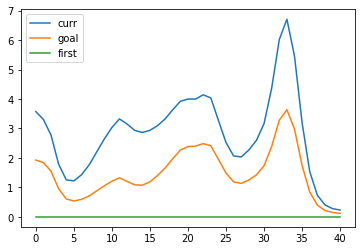

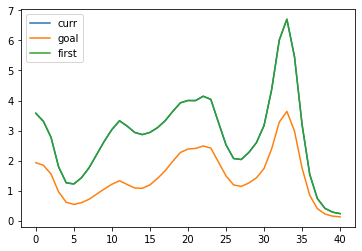

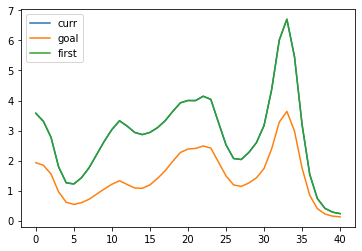

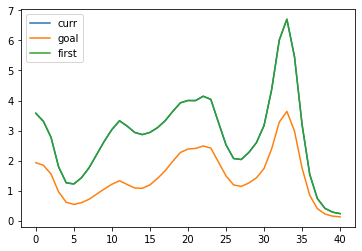

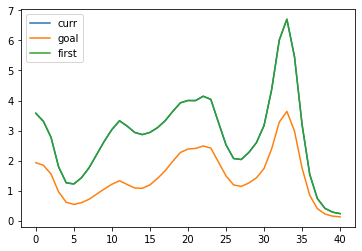

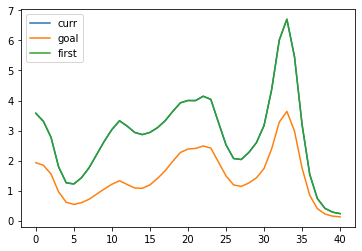

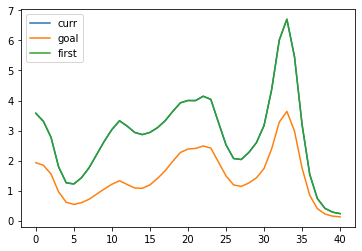

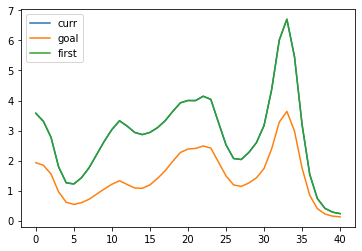

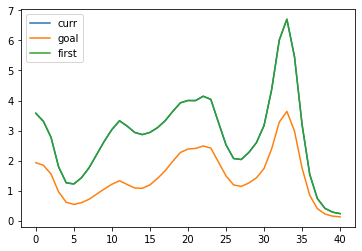

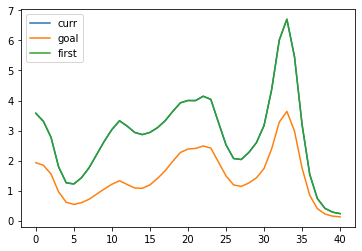

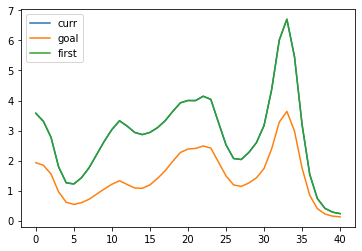

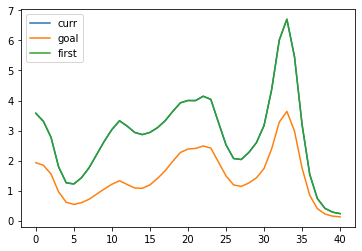

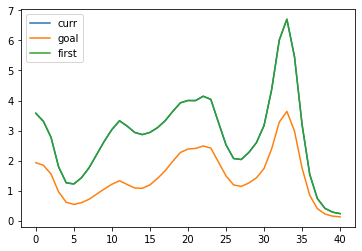

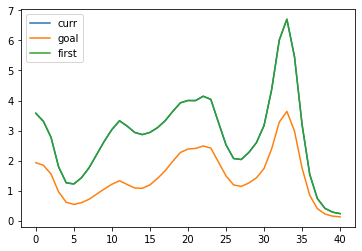

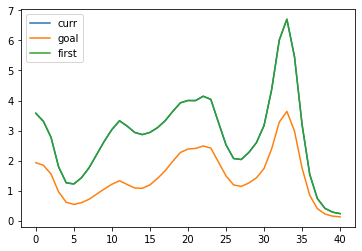

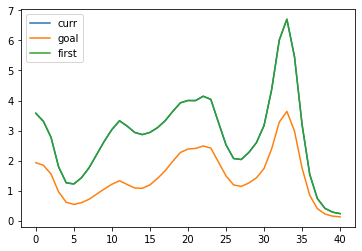

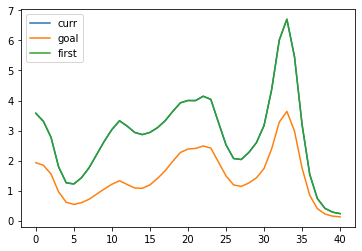

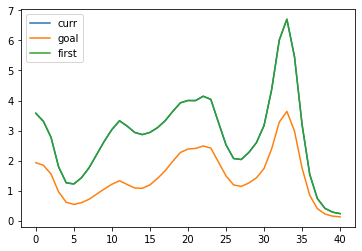

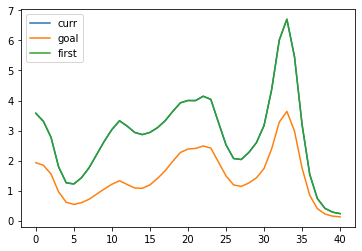

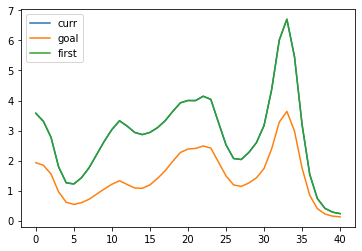

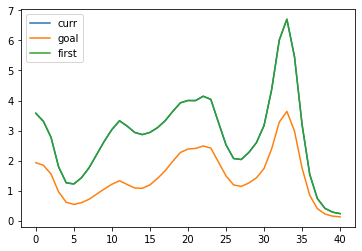

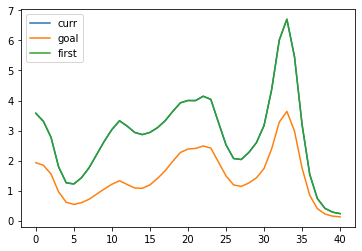

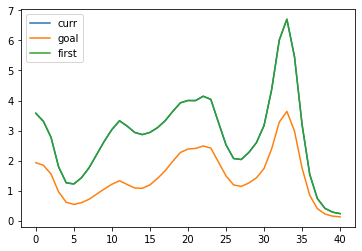

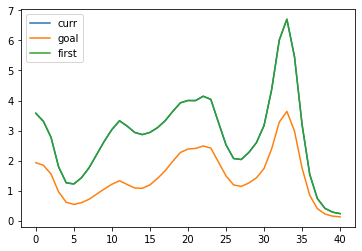

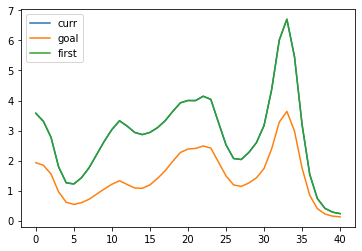

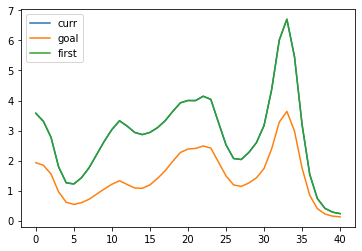

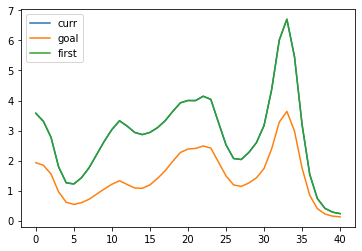

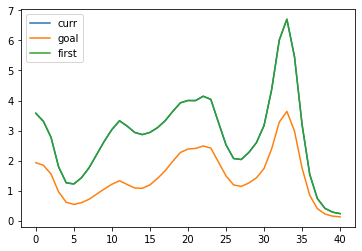

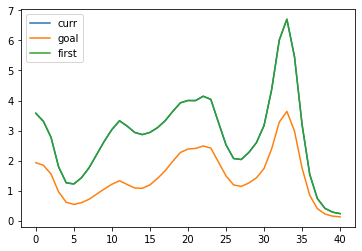

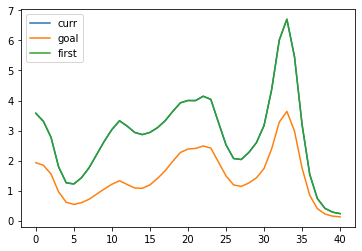

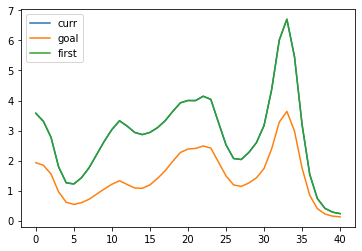

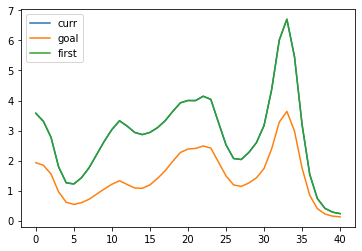

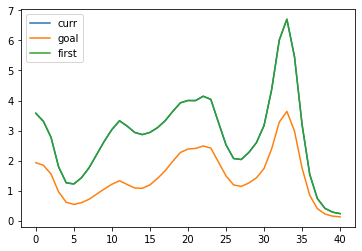

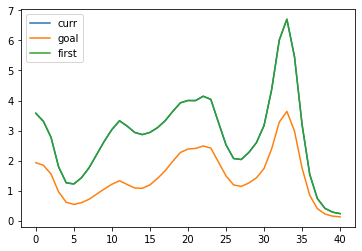

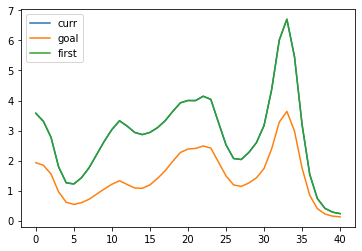

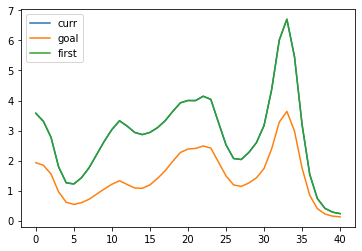

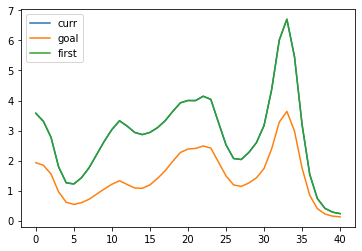

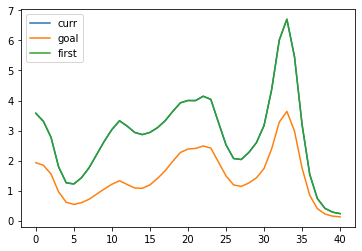

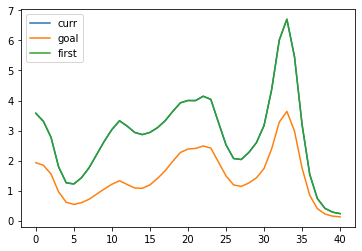

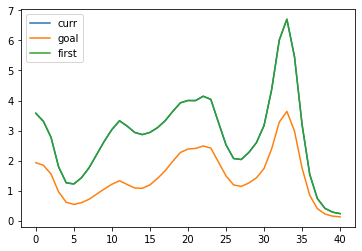

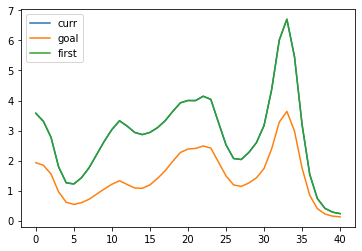

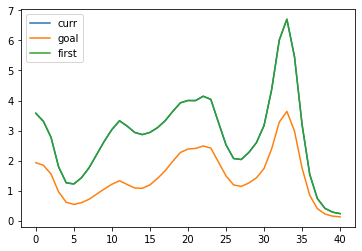

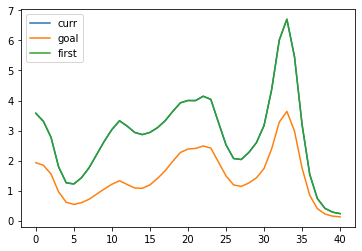

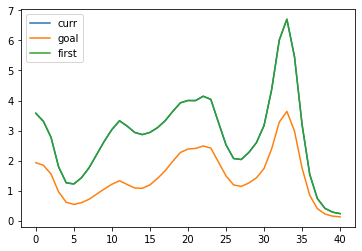

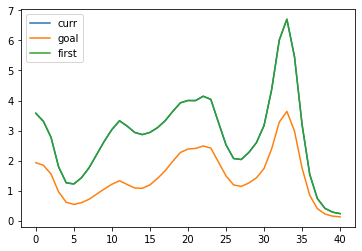

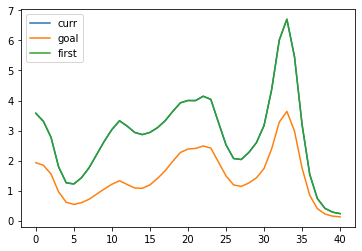

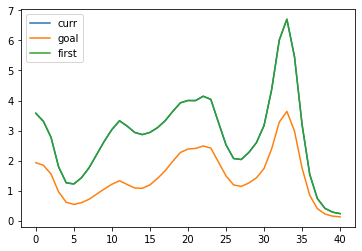

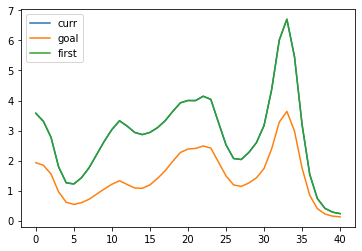

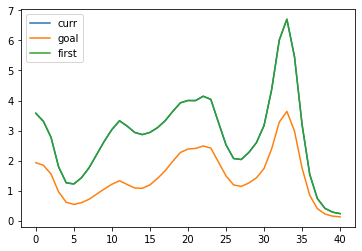

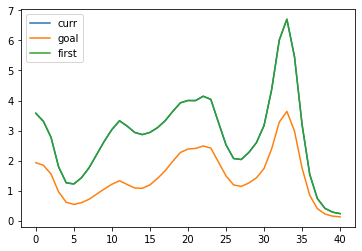

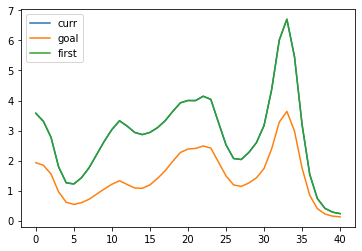

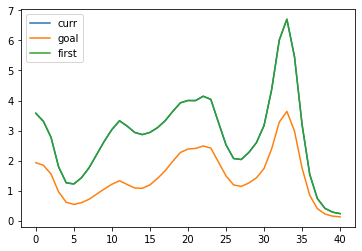

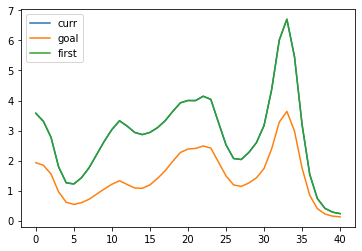

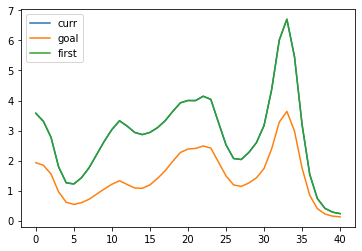

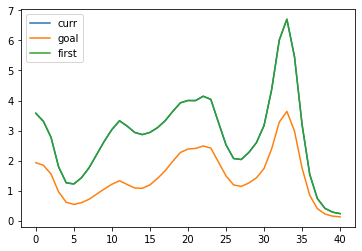

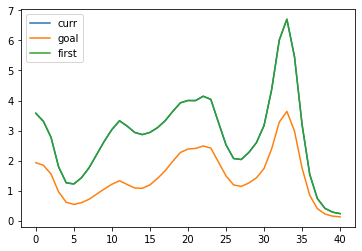

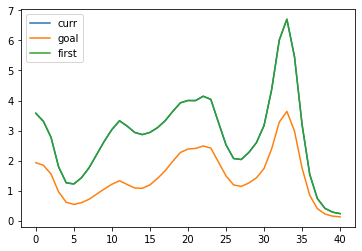

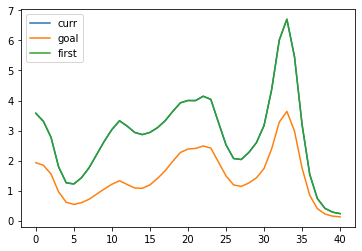

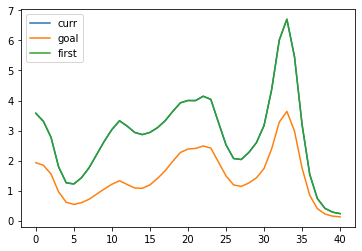

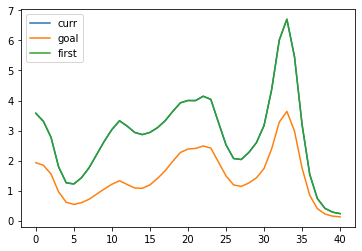

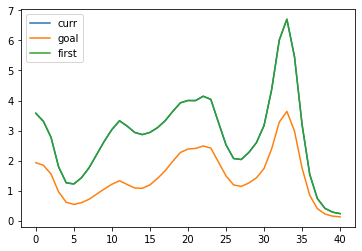

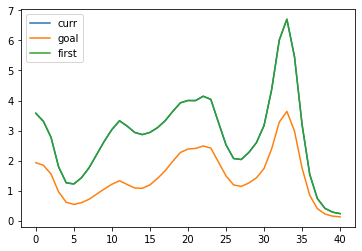

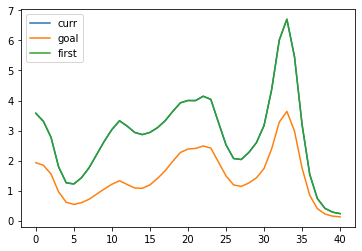

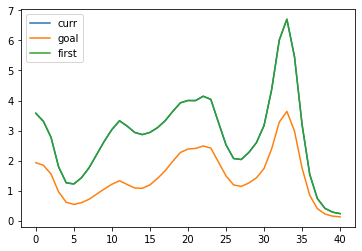

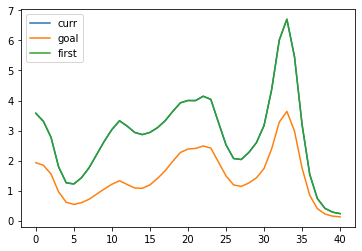

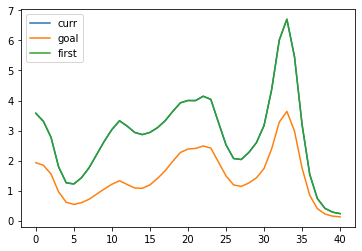

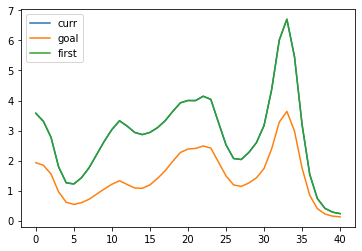

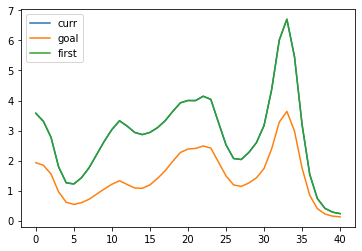

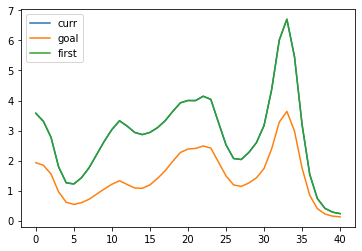

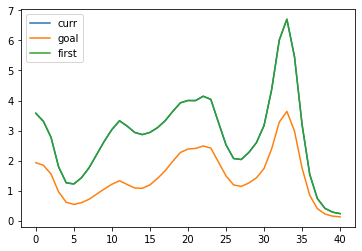

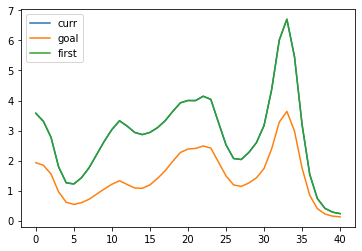

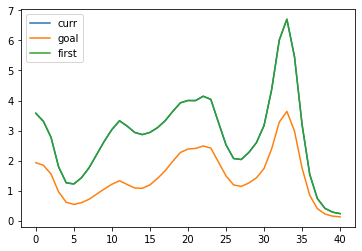

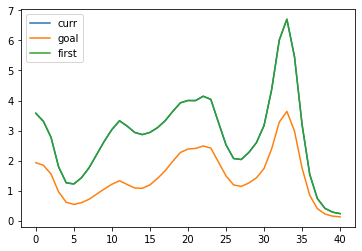

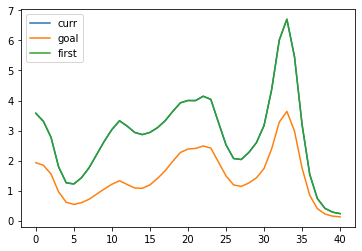

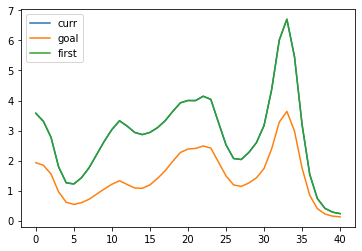

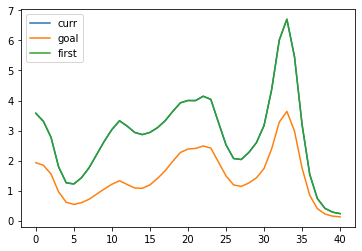

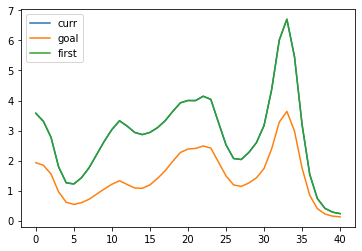

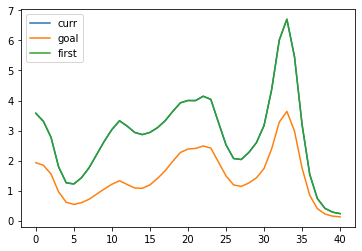

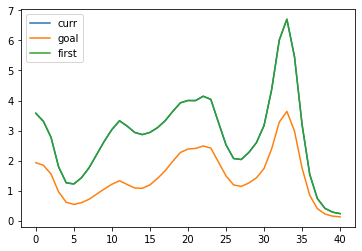

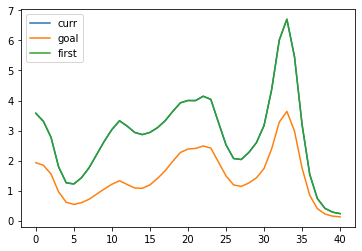

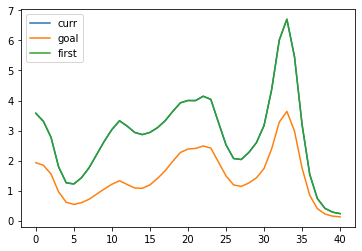

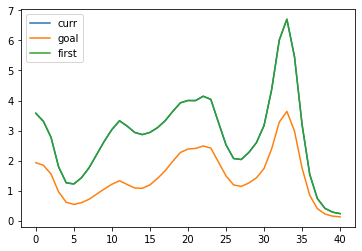

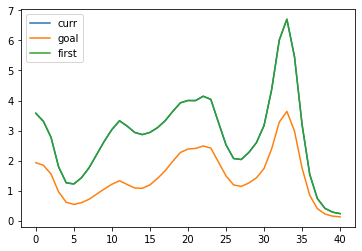

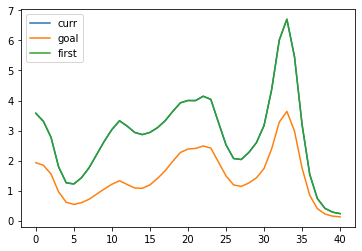

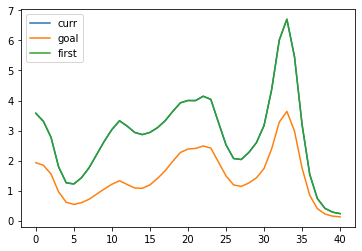

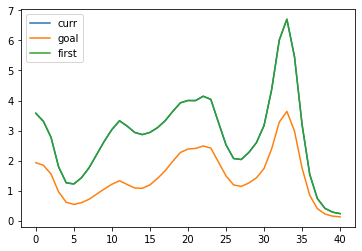

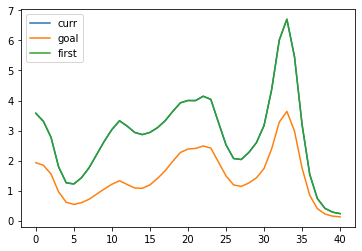

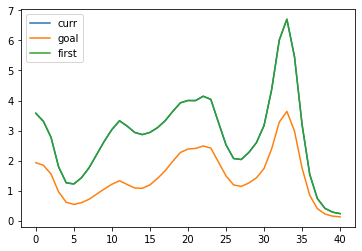

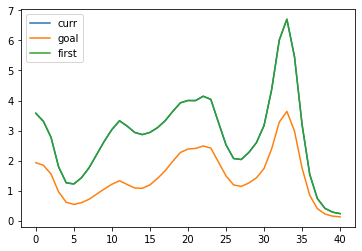

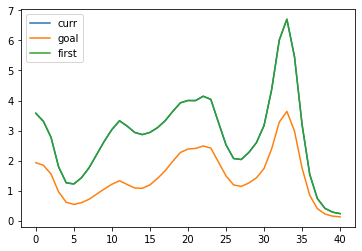

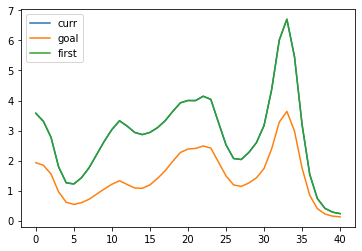

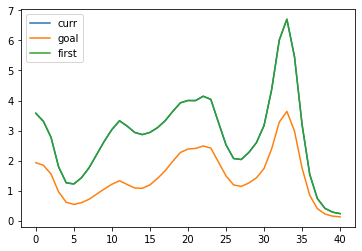

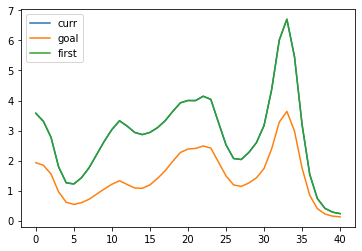

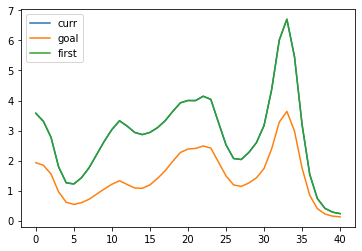

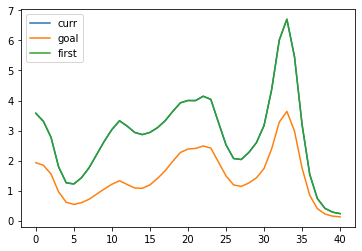

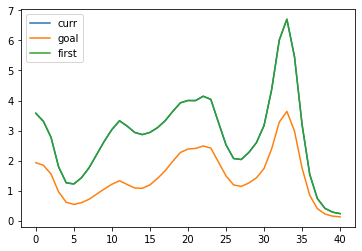

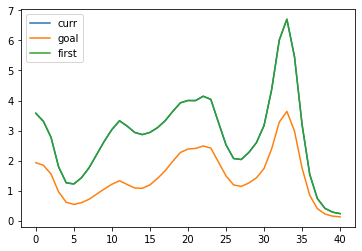

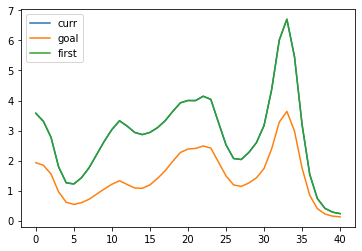

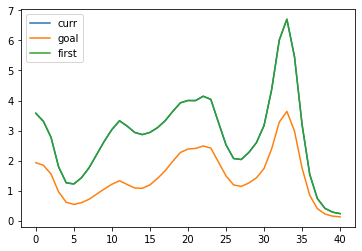

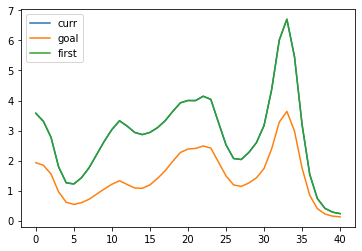

In [9]:
reward_list = []

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        state, reward, done, info = env.step(action)


        obs_tuple = (prev_state, action, reward, state)
        buffer.record(obs_tuple)
        episodic_reward += reward


        x, y = buffer.learn()
        # End this episode when `done` is True
        if done:
            break

        prev_state = state
    reward_list.append(episodic_reward)